In [1]:
!pip install --upgrade quantecon
!pip install --upgrade optax
!pip install --upgrade statsmodels

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)


Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)


  Using cached statsmodels-0.14.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.2 kB)
Using cached statsmodels-0.14.4-cp312-cp312-macosx_11_0_arm64.whl (9.9 MB)


  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.14.2


    Uninstalling statsmodels-0.14.2:


      Successfully uninstalled statsmodels-0.14.2


In [2]:
from quantecon import LQ
import numpy as np
import jax.numpy as jnp
from jax import jit, grad
import optax
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
class ChangLQ:
    """
    Class to solve LQ Chang model
    """
    def __init__(self, β, c, α=1, u0=1, u1=0.5, u2=3, T=1000, θ_n=200):
        # Record parameters
        self.α, self.u0, self.u1, self.u2 = α, u0, u1, u2
        self.β, self.c, self.T, self.θ_n = β, c, T, θ_n

        self.setup_LQ_matrices()
        self.solve_LQ_problem()
        self.compute_policy_functions()
        self.simulate_ramsey_plan()
        self.compute_θ_range()
        self.compute_value_and_policy()

    def setup_LQ_matrices(self):
        # LQ Matrices
        self.R = -np.array([[self.u0, -self.u1 * self.α / 2],
                            [-self.u1 * self.α / 2, 
                             -self.u2 * self.α**2 / 2]])
        self.Q = -np.array([[-self.c / 2]])
        self.A = np.array([[1, 0], [0, (1 + self.α) / self.α]])
        self.B = np.array([[0], [-1 / self.α]])

    def solve_LQ_problem(self):
        # Solve LQ Problem (Subproblem 1)
        lq = LQ(self.Q, self.R, self.A, self.B, beta=self.β)
        self.P, self.F, self.d = lq.stationary_values()

        # Compute g0, g1, and g2 (41.16)
        self.g0, self.g1, self.g2 = [-self.P[0, 0], 
                                     -2 * self.P[1, 0], -self.P[1, 1]]
        
        # Compute b0 and b1 (41.17)
        [[self.b0, self.b1]] = self.F

        # Compute d0 and d1 (41.18)
        self.cl_mat = (self.A - self.B @ self.F)  # Closed loop matrix
        [[self.d0, self.d1]] = self.cl_mat[1:]

        # Solve Subproblem 2
        self.θ_R = -self.P[0, 1] / self.P[1, 1]
        
        # Find the bliss level of θ
        self.θ_B = -self.u1 / (self.u2 * self.α)

    def compute_policy_functions(self):
        # Solve the Markov Perfect Equilibrium
        self.μ_MPE = -self.u1 / ((1 + self.α) / self.α * self.c 
                                 + self.α / (1 + self.α)
                                 * self.u2 + self.α**2 
                                 / (1 + self.α) * self.u2)
        self.θ_MPE = self.μ_MPE
        self.μ_CR = -self.α * self.u1 / (self.u2 * self.α**2 + self.c)
        self.θ_CR = self.μ_CR

        # Calculate value under MPE and CR economy
        self.J_θ = lambda θ_array: - np.array([1, θ_array]) \
                                   @ self.P @ np.array([1, θ_array]).T
        self.V_θ = lambda θ: (self.u0 + self.u1 * (-self.α * θ)
                              - self.u2 / 2 * (-self.α * θ)**2 
                              - self.c / 2 * θ**2) / (1 - self.β)
        
        self.J_MPE = self.V_θ(self.μ_MPE)
        self.J_CR = self.V_θ(self.μ_CR)

    def simulate_ramsey_plan(self):
        # Simulate Ramsey plan for large number of periods
        θ_series = np.vstack((np.ones((1, self.T)), np.zeros((1, self.T))))
        μ_series = np.zeros(self.T)
        J_series = np.zeros(self.T)
        θ_series[1, 0] = self.θ_R
        [μ_series[0]] = -self.F.dot(θ_series[:, 0])
        J_series[0] = self.J_θ(θ_series[1, 0])

        for i in range(1, self.T):
            θ_series[:, i] = self.cl_mat @ θ_series[:, i-1]
            [μ_series[i]] = -self.F @ θ_series[:, i]
            J_series[i] = self.J_θ(θ_series[1, i])

        self.J_series = J_series
        self.μ_series = μ_series
        self.θ_series = θ_series

    def compute_θ_range(self):
        # Find the range of θ in Ramsey plan
        θ_LB = min(min(self.θ_series[1, :]), self.θ_B)
        θ_UB = max(max(self.θ_series[1, :]), self.θ_MPE)
        θ_range = θ_UB - θ_LB
        self.θ_LB = θ_LB - 0.05 * θ_range
        self.θ_UB = θ_UB + 0.05 * θ_range
        self.θ_range = θ_range

    def compute_value_and_policy(self):        
        # Create the θ_space
        self.θ_space = np.linspace(self.θ_LB, self.θ_UB, 200)
        
        # Find value function and policy functions over range of θ
        self.J_space = np.array([self.J_θ(θ) for θ in self.θ_space])
        self.μ_space = -self.F @ np.vstack((np.ones(200), self.θ_space))
        x_prime = self.cl_mat @ np.vstack((np.ones(200), self.θ_space))
        self.θ_prime = x_prime[1, :]
        self.CR_space = np.array([self.V_θ(θ) for θ in self.θ_space])
        
        self.μ_space = self.μ_space[0, :]
        
        # Calculate J_range, J_LB, and J_UB
        self.J_range = np.ptp(self.J_space)
        self.J_LB = np.min(self.J_space) - 0.05 * self.J_range
        self.J_UB = np.max(self.J_space) + 0.05 * self.J_range

In [4]:
# Assume β=0.85, c=2, T=40.
T = 40
clq = ChangLQ(β=0.85, c=2, T=T)

In [5]:
@jit
def compute_θ(μ, α=1):
    λ = α / (1 + α)
    T = len(μ) - 1
    μbar = μ[-1]
    
    # Create an array of powers for λ
    λ_powers = λ ** jnp.arange(T + 1)
    
    # Compute the weighted sums for all t
    weighted_sums = jnp.array(
        [jnp.sum(λ_powers[:T-t] * μ[t:T]) for t in range(T)])
    
    # Compute θ values except for the last element
    θ = (1 - λ) * weighted_sums + λ**(T - jnp.arange(T)) * μbar
    
    # Set the last element
    θ = jnp.append(θ, μbar)
    
    return θ

@jit
def compute_hs(u0, u1, u2, α):
    h0 = u0
    h1 = -u1 * α
    h2 = -0.5 * u2 * α**2
    
    return h0, h1, h2
    
@jit
def compute_V(μ, β, c, α=1, u0=1, u1=0.5, u2=3):
    θ = compute_θ(μ, α)
    
    h0, h1, h2 = compute_hs(u0, u1, u2, α)
    
    T = len(μ) - 1
    t = np.arange(T)
    
    # Compute sum except for the last element
    V_sum = np.sum(β**t * (h0 + h1 * θ[:T] + h2 * θ[:T]**2 - 0.5 * c * μ[:T]**2))
    
    # Compute the final term
    V_final = (β**T / (1 - β)) * (h0 + h1 * μ[-1] + h2 * μ[-1]**2 - 0.5 * c * μ[-1]**2)
    
    V = V_sum + V_final
    
    return V

In [6]:
V_val = compute_V(clq.μ_series, β=0.85, c=2)

# Check the result with the ChangLQ class in previous lecture
print(f'deviation = {np.abs(V_val - clq.J_series[0])}') # good!

deviation = 9.5367431640625e-07


In [7]:
def adam_optimizer(grad_func, init_params, 
                   lr=0.1, 
                   max_iter=10_000, 
                   error_tol=1e-7):

    # Set initial parameters and optimizer
    params = init_params
    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(params)

    # Update parameters and gradients
    @jit
    def update(params, opt_state):
        grads = grad_func(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, grads

    # Gradient descent loop
    for i in range(max_iter):
        params, opt_state, grads = update(params, opt_state)
        
        if jnp.linalg.norm(grads) < error_tol:
            print(f"Converged after {i} iterations.")
            break

        if i % 100 == 0: 
            print(f"Iteration {i}, grad norm: {jnp.linalg.norm(grads)}")
    
    return params

In [8]:
# Initial guess for μ
μ_init = jnp.zeros(T)

# Maximization instead of minimization
grad_V = jit(grad(
    lambda μ: -compute_V(μ, β=0.85, c=2)))

In [9]:
%%time

# Optimize μ
optimized_μ = adam_optimizer(grad_V, μ_init)

print(f"optimized μ = \n{optimized_μ}")

Iteration 0, grad norm: 0.8627105951309204
Iteration 100, grad norm: 0.003303048899397254
Iteration 200, grad norm: 1.6914522348088212e-05
Converged after 286 iterations.
optimized μ = 
[-0.06450713 -0.09033986 -0.1006849  -0.10482774 -0.10648678 -0.10715117
 -0.10741721 -0.10752378 -0.10756645 -0.10758355 -0.10759039 -0.10759313
 -0.10759424 -0.10759469 -0.10759486 -0.10759492 -0.10759494 -0.10759494
 -0.10759494 -0.10759498 -0.10759494 -0.10759494 -0.10759494 -0.10759497
 -0.10759496 -0.10759494 -0.10759495 -0.10759494 -0.10759494 -0.10759493
 -0.10759494 -0.10759497 -0.10759497 -0.107595   -0.107595   -0.10759501
 -0.10759502 -0.10759503 -0.10759503 -0.10759509]
CPU times: user 459 ms, sys: 38.1 ms, total: 497 ms
Wall time: 352 ms


In [10]:
print(f"original μ = \n{clq.μ_series}")

original μ = 
[-0.06450708 -0.09033982 -0.10068489 -0.10482772 -0.10648677 -0.10715115
 -0.10741722 -0.10752377 -0.10756644 -0.10758352 -0.10759037 -0.10759311
 -0.1075942  -0.10759464 -0.10759482 -0.10759489 -0.10759492 -0.10759493
 -0.10759493 -0.10759494 -0.10759494 -0.10759494 -0.10759494 -0.10759494
 -0.10759494 -0.10759494 -0.10759494 -0.10759494 -0.10759494 -0.10759494
 -0.10759494 -0.10759494 -0.10759494 -0.10759494 -0.10759494 -0.10759494
 -0.10759494 -0.10759494 -0.10759494 -0.10759494]


In [11]:
print(f'deviation = {np.linalg.norm(optimized_μ - clq.μ_series)}')

deviation = 2.8730659096254385e-07


In [12]:
compute_V(optimized_μ, β=0.85, c=2)

Array(6.8357825, dtype=float32)

In [13]:
compute_V(clq.μ_series, β=0.85, c=2)

Array(6.8357825, dtype=float32)

In [14]:
# Initial guess for single μ
μ_init = jnp.zeros(1)

# Maximization instead of minimization
grad_V = jit(grad(
    lambda μ: -compute_V(μ, β=0.85, c=2)))

# Optimize μ
optimized_μ_CR = adam_optimizer(grad_V, μ_init)

print(f"optimized μ = \n{optimized_μ_CR}")

Iteration 0, grad norm: 3.333333969116211
Iteration 100, grad norm: 0.0049784183502197266
Iteration 200, grad norm: 6.771087646484375e-05
Converged after 282 iterations.
optimized μ = 
[-0.10000004]


In [15]:
np.linalg.norm(clq.μ_CR - optimized_μ_CR)

3.7252903e-08

In [16]:
V_CR = compute_V(optimized_μ_CR, β=0.85, c=2)
V_CR

Array(6.8333354, dtype=float32)

In [17]:
compute_V(jnp.array([clq.μ_CR]), β=0.85, c=2)

Array(6.8333344, dtype=float32)

In [18]:
def construct_B(α, T):
    λ = α / (1 + α)
    
    A = (jnp.eye(T, T) - λ*jnp.eye(T, T, k=1))/(1-λ)
    A = A.at[-1, -1].set(A[-1, -1]*(1-λ))

    B = jnp.linalg.inv(A)
    return A, B

In [19]:
A, B = construct_B(α=clq.α, T=T)

print(f'A = \n {A}')

A = 
 [[ 2. -1.  0. ...  0.  0.  0.]
 [ 0.  2. -1. ...  0.  0.  0.]
 [ 0.  0.  2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  2. -1.  0.]
 [ 0.  0.  0. ...  0.  2. -1.]
 [ 0.  0.  0. ...  0.  0.  1.]]


In [20]:
# Compute θ using optimized_μ
θs = np.array(compute_θ(optimized_μ))
μs = np.array(optimized_μ)

In [21]:
np.allclose(θs, B @ clq.μ_series)

True

In [22]:
def compute_J(μ, β, c, α=1, u0=1, u1=0.5, u2=3):
    T = len(μ) - 1
    
    h0, h1, h2 = compute_hs(u0, u1, u2, α)
    λ = α / (1 + α)
    
    _, B = construct_B(α, T+1)
    
    β_vec = jnp.hstack([β**jnp.arange(T),
                       (β**T/(1-β))])
    
    θ = B @ μ
    βθ_sum = jnp.sum((β_vec * h1) * θ)
    βθ_square_sum = β_vec * h2 * θ.T @ θ
    βμ_square_sum = 0.5 * c * β_vec * μ.T @ μ
    
    return βθ_sum + βθ_square_sum - βμ_square_sum

In [23]:
# Initial guess for μ
μ_init = jnp.zeros(T)

# Maximization instead of minimization
grad_J = jit(grad(
    lambda μ: -compute_J(μ, β=0.85, c=2)))

In [24]:
%%time

# Optimize μ
optimized_μ = adam_optimizer(grad_J, μ_init)

print(f"optimized μ = \n{optimized_μ}")

Iteration 0, grad norm: 0.8627105951309204
Iteration 100, grad norm: 0.003303023288026452
Iteration 200, grad norm: 1.6917430912144482e-05
Converged after 280 iterations.
optimized μ = 
[-0.0645071  -0.09033986 -0.10068493 -0.10482775 -0.10648679 -0.10715119
 -0.10741723 -0.10752378 -0.10756644 -0.10758354 -0.1075904  -0.10759313
 -0.10759426 -0.10759471 -0.10759488 -0.10759496 -0.10759498 -0.10759499
 -0.10759498 -0.10759497 -0.10759495 -0.10759497 -0.10759495 -0.10759498
 -0.10759497 -0.10759498 -0.10759499 -0.10759497 -0.10759497 -0.10759496
 -0.10759494 -0.10759495 -0.10759493 -0.10759494 -0.10759494 -0.10759495
 -0.10759496 -0.107595   -0.10759497 -0.10759496]
CPU times: user 1.2 s, sys: 368 ms, total: 1.57 s
Wall time: 250 ms


In [25]:
print(f"original μ = \n{clq.μ_series}")

original μ = 
[-0.06450708 -0.09033982 -0.10068489 -0.10482772 -0.10648677 -0.10715115
 -0.10741722 -0.10752377 -0.10756644 -0.10758352 -0.10759037 -0.10759311
 -0.1075942  -0.10759464 -0.10759482 -0.10759489 -0.10759492 -0.10759493
 -0.10759493 -0.10759494 -0.10759494 -0.10759494 -0.10759494 -0.10759494
 -0.10759494 -0.10759494 -0.10759494 -0.10759494 -0.10759494 -0.10759494
 -0.10759494 -0.10759494 -0.10759494 -0.10759494 -0.10759494 -0.10759494
 -0.10759494 -0.10759494 -0.10759494 -0.10759494]


In [26]:
print(f'deviation = {np.linalg.norm(optimized_μ - clq.μ_series)}')

deviation = 2.318076610663411e-07


In [27]:
V_R = compute_V(optimized_μ, β=0.85, c=2)
V_R

Array(6.8357825, dtype=float32)

In [28]:
def compute_μ(β, c, T, α=1, u0=1, u1=0.5, u2=3):    
    h0, h1, h2 = compute_hs(u0, u1, u2, α)
    
    _, B = construct_B(α, T+1)
    
    β_vec = jnp.hstack([β**jnp.arange(T),
                       (β**T/(1-β))])
    
    g = h1 * B.T @ β_vec
    M = B.T @ (h2 * jnp.diag(β_vec)) @ B
    F = c/2 * jnp.diag(β_vec)
    G = M - F
    return jnp.linalg.solve(2*G, -g)

μ_closed = compute_μ(β=0.85, c=2, T=T-1)
print(f'closed-form μ = \n{μ_closed}')

closed-form μ = 
[-0.0645071  -0.09033981 -0.1006849  -0.10482775 -0.10648677 -0.10715112
 -0.10741723 -0.10752376 -0.10756642 -0.10758352 -0.10759033 -0.10759313
 -0.10759421 -0.10759464 -0.10759483 -0.10759491 -0.10759489 -0.10759494
 -0.10759493 -0.10759493 -0.10759497 -0.10759491 -0.10759494 -0.10759494
 -0.10759494 -0.1075949  -0.10759493 -0.10759491 -0.10759497 -0.10759496
 -0.10759497 -0.10759491 -0.10759494 -0.10759491 -0.10759496 -0.10759495
 -0.10759493 -0.10759494 -0.10759494 -0.10759494]


In [29]:
print(f'deviation = {np.linalg.norm(μ_closed - clq.μ_series)}')

deviation = 1.2400236926168873e-07


In [30]:
compute_V(μ_closed, β=0.85, c=2)

Array(6.8357825, dtype=float32)

In [31]:
print(f'deviation = {np.linalg.norm(B @ μ_closed - θs)}')

deviation = 3.041078286969423e-07


In [32]:
def compute_grad(μ, β, c, α=1, u0=1, u1=0.5, u2=3):    
    T = len(μ) - 1
    
    h0, h1, h2 = compute_hs(u0, u1, u2, α)
    
    _, B = construct_B(α, T+1)
    
    β_vec = jnp.hstack([β**jnp.arange(T),
                       (β**T/(1-β))])
    
    g = h1 * B.T @ β_vec
    M = (h2 * B.T @ jnp.diag(β_vec) @ B)
    F = c/2 * jnp.diag(β_vec)
    G = M - F
    return g + (2*G @ μ)

closed_grad = compute_grad(jnp.ones(T), β=0.85, c=2)

In [33]:
closed_grad

Array([-3.75      , -4.0625    , -3.8906248 , -3.5257814 , -3.1062894 ,
       -2.6950338 , -2.3181221 , -1.9840758 , -1.6933005 , -1.4427234 ,
       -1.2280239 , -1.0446748 , -0.8884009 , -0.7553545 , -0.64215815,
       -0.5458878 , -0.4640314 , -0.39444003, -0.3352807 , -0.28499195,
       -0.24224482, -0.20590895, -0.17502302, -0.14876978, -0.12645441,
       -0.10748631, -0.09136339, -0.07765889, -0.06601007, -0.05610856,
       -0.04769228, -0.04053845, -0.03445768, -0.02928903, -0.02489568,
       -0.02116132, -0.01798713, -0.01528906, -0.0129957 , -0.07364223],      dtype=float32)

In [34]:
- grad_J(jnp.ones(T))

Array([-3.75      , -4.0625    , -3.890625  , -3.5257816 , -3.1062894 ,
       -2.6950336 , -2.3181224 , -1.9840759 , -1.6933005 , -1.4427235 ,
       -1.228024  , -1.0446749 , -0.8884009 , -0.7553544 , -0.6421581 ,
       -0.54588777, -0.46403137, -0.39444   , -0.33528066, -0.28499192,
       -0.24224481, -0.20590894, -0.175023  , -0.14876977, -0.12645441,
       -0.10748631, -0.0913634 , -0.0776589 , -0.06601007, -0.05610857,
       -0.04769228, -0.04053844, -0.03445768, -0.02928903, -0.02489568,
       -0.02116132, -0.01798712, -0.01528906, -0.0129957 , -0.07364222],      dtype=float32)

In [35]:
print(f'deviation = {np.linalg.norm(closed_grad - (- grad_J(jnp.ones(T))))}')

deviation = 5.571309884544462e-07


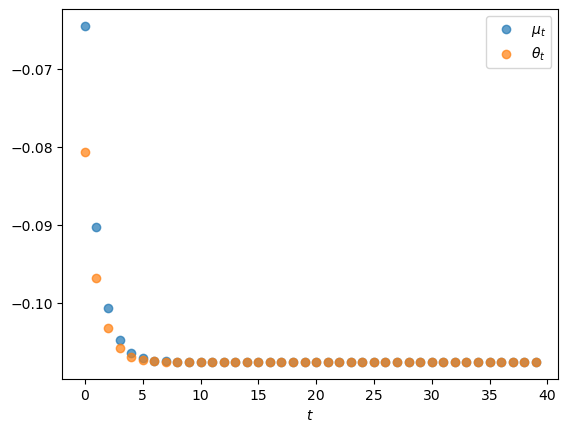

In [36]:
# Compute θ using optimized_μ
θs = np.array(compute_θ(optimized_μ))
μs = np.array(optimized_μ)

# Plot the two sequences
Ts = np.arange(T)

plt.scatter(Ts, μs, label=r'$\mu_t$', alpha=0.7)
plt.scatter(Ts, θs, label=r'$\theta_t$', alpha=0.7)
plt.xlabel(r'$t$')
plt.legend()
plt.show()

In [37]:
# Define function for s and U in section 41.3
def s(θ, μ, u0, u1, u2, α, c):
    U = lambda x: u0 + u1 * x - (u2 / 2) * x**2
    return U(-α*θ) - (c / 2) * μ**2

# Calculate v_t sequence backward
def compute_vt(μ, β, c, u0=1, u1=0.5, u2=3, α=1):
    T = len(μs)
    θ = compute_θ(μ, α)
    
    v_t = np.zeros(T)
    μ_bar = μs[-1]
    
    # Reduce parameters
    s_p = lambda θ, μ: s(θ, μ, 
                       u0=u0, u1=u1, u2=u2, α=α, c=c)
    
    # Define v_T
    v_t[T-1] = (1 / (1 - β)) * s_p(μ_bar, μ_bar)
    
    # Backward iteration
    for t in reversed(range(T-1)):
        v_t[t] = s_p(θ[t], μ[t]) + β * v_t[t+1]
        
    return v_t

v_t = compute_vt(μs, β=0.85, c=2)

In [38]:
print(f'deviation = {np.linalg.norm(v_t[0] - V_R)}')

deviation = 4.76837158203125e-07


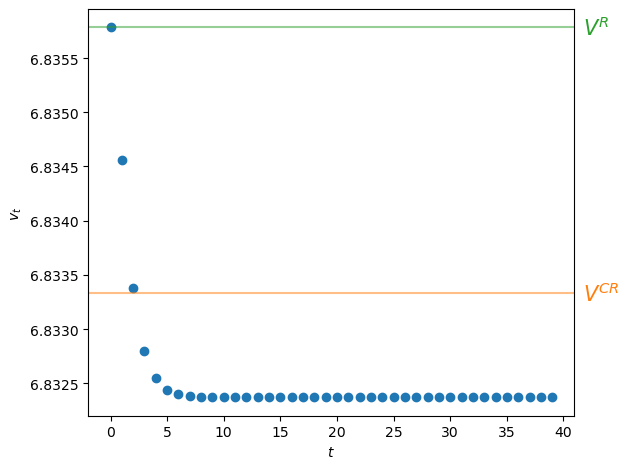

In [39]:
# Plot the scatter plot
plt.scatter(Ts, v_t, label='$v_t$')

# Plot horizontal lines
plt.axhline(V_CR, color='C1', alpha=0.5)
plt.axhline(V_R, color='C2', alpha=0.5)

# Add labels
plt.text(max(Ts) + max(Ts)*0.07, V_CR, '$V^{CR}$', color='C1', 
         va='center', clip_on=False, fontsize=15)
plt.text(max(Ts) + max(Ts)*0.07, V_R, '$V^R$', color='C2', 
         va='center', clip_on=False, fontsize=15)
plt.xlabel(r'$t$')
plt.ylabel(r'$v_t$')

plt.tight_layout()
plt.show()

In [40]:
# First regression: μ_t on a constant and θ_t
X1_θ = sm.add_constant(θs)
model1 = sm.OLS(μs, X1_θ)
results1 = model1.fit()

# Print regression summary
print("Regression of μ_t on a constant and θ_t:")
print(results1.summary(slim=True))

Regression of μ_t on a constant and θ_t:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
No. Observations:                  40   F-statistic:                 1.531e+13
Covariance Type:            nonrobust   Prob (F-statistic):          4.07e-222
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0645   4.36e-08   1.48e+06      0.000       0.065       0.065
x1             1.5995   4.09e-07   3.91e+06      0.000       1.600       1.600

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


<>:2: SyntaxWarning: invalid escape sequence '\h'
<>:2: SyntaxWarning: invalid escape sequence '\h'
/var/folders/zy/dpt7pvt11fvcm_yxjd7kmv880000gn/T/ipykernel_55684/68086905.py:2: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(θs, results1.predict(X1_θ), 'grey', label='$\hat \mu_t$', linestyle='--')


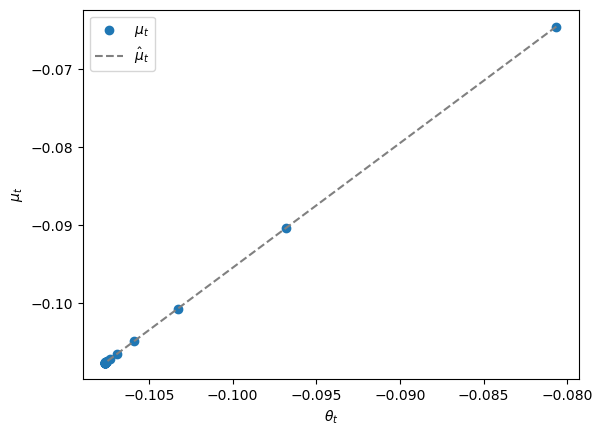

In [41]:
plt.scatter(θs, μs, label=r'$\mu_t$')
plt.plot(θs, results1.predict(X1_θ), 'grey', label='$\hat \mu_t$', linestyle='--')
plt.xlabel(r'$\theta_t$')
plt.ylabel(r'$\mu_t$')
plt.legend()
plt.show()

In [42]:
# Second regression: θ_{t+1} on a constant and θ_t
θ_t = np.array(θs[:-1])  # θ_t
θ_t1 = np.array(θs[1:])  # θ_{t+1}
X2_θ = sm.add_constant(θ_t)  # Add a constant term for the intercept
model2 = sm.OLS(θ_t1, X2_θ)
results2 = model2.fit()

# Print regression summary
print("\nRegression of θ_{t+1} on a constant and θ_t:")
print(results2.summary(slim=True))


Regression of θ_{t+1} on a constant and θ_t:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
No. Observations:                  39   F-statistic:                 8.747e+11
Covariance Type:            nonrobust   Prob (F-statistic):          1.59e-193
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0645   4.56e-08  -1.41e+06      0.000      -0.065      -0.065
x1             0.4005   4.28e-07   9.35e+05      0.000       0.400       0.400

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


<>:2: SyntaxWarning: invalid escape sequence '\h'
<>:2: SyntaxWarning: invalid escape sequence '\h'
/var/folders/zy/dpt7pvt11fvcm_yxjd7kmv880000gn/T/ipykernel_55684/154331351.py:2: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(θ_t, results2.predict(X2_θ), color='grey', label='$\hat θ_{t+1}$', linestyle='--')


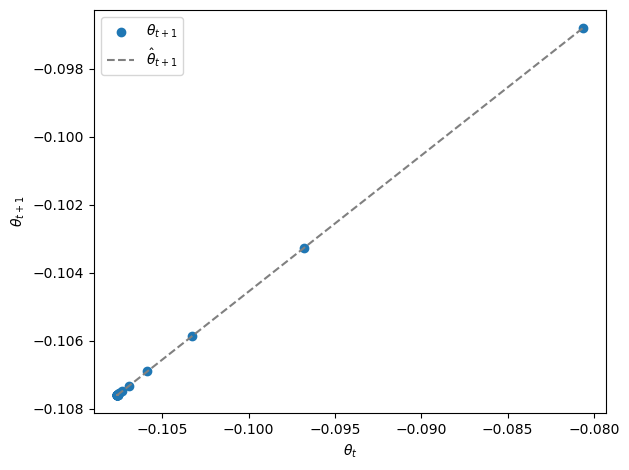

In [43]:
plt.scatter(θ_t, θ_t1, label=r'$\theta_{t+1}$')
plt.plot(θ_t, results2.predict(X2_θ), color='grey', label='$\hat θ_{t+1}$', linestyle='--')
plt.xlabel(r'$\theta_t$')
plt.ylabel(r'$\theta_{t+1}$')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
# Third regression: v_t on a constant, θ_t and θ^2_t
X3_θ = np.column_stack((np.ones(T), θs, θs**2))
model3 = sm.OLS(v_t, X3_θ)
results3 = model3.fit()


# Print regression summary
print("\nRegression of v_t on a constant, θ_t and θ^2_t:")
print(results3.summary(slim=True))


Regression of v_t on a constant, θ_t and θ^2_t:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
No. Observations:                  40   F-statistic:                 5.514e+08
Covariance Type:            nonrobust   Prob (F-statistic):          5.31e-139
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8052   5.89e-06   1.15e+06      0.000       6.805       6.805
x1            -0.7581      0.000  -6051.126      0.000      -0.758      -0.758
x2            -4.6996      0.001  -7158.090      0.000      -4.701      -4.698

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+04. This might indica

In [45]:
np.corrcoef(θs, θs**2)

array([[ 1.        , -0.99942155],
       [-0.99942155,  1.        ]])

<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\h'
/var/folders/zy/dpt7pvt11fvcm_yxjd7kmv880000gn/T/ipykernel_55684/203801373.py:6: SyntaxWarning: invalid escape sequence '\h'
  label='$\hat v_t$', linestyle='--')


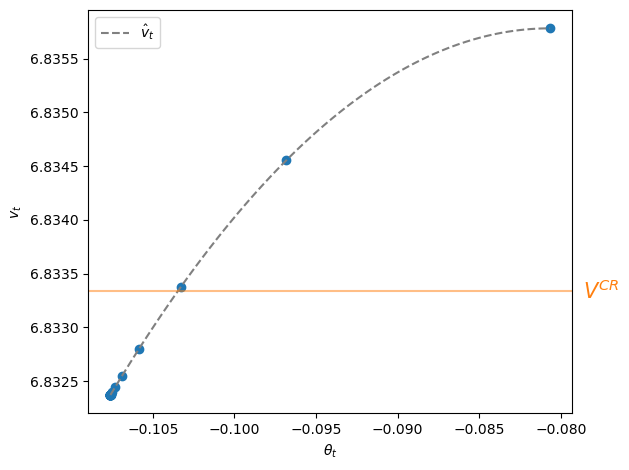

In [46]:
θ_grid = np.linspace(min(θs), max(θs), 100)
X3_grid = np.column_stack((np.ones(len(θ_grid)), θ_grid, θ_grid**2))

plt.scatter(θs, v_t)
plt.plot(θ_grid, results3.predict(X3_grid), color='grey', 
         label='$\hat v_t$', linestyle='--')
plt.axhline(V_CR, color='C1', alpha=0.5)

plt.text(max(θ_grid) - max(θ_grid)*0.025, V_CR, '$V^{CR}$', color='C1', 
         va='center', clip_on=False, fontsize=15)

plt.xlabel(r'$\theta_{t}$')
plt.ylabel(r'$v_t$')
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
clq = ChangLQ(β=0.85, c=2, T=T)

In [48]:
print("decision rule for μ")
print(f'-(b_0, b_1) = ({-clq.b0:.6f}, {-clq.b1:.6f})')

decision rule for μ
-(b_0, b_1) = (0.064507, 1.599536)


In [49]:
print("decision rule for θ(t+1) as function of θ(t)")
print(f'(d_0, d_1) =  ({clq.d0:.6f}, {clq.d1:.6f})')

decision rule for θ(t+1) as function of θ(t)
(d_0, d_1) =  (-0.064507, 0.400464)
